import

In [1]:
import numpy as np
import cv2
import random
import math
from matplotlib import pyplot as plt
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

img = cv2.imread("circle.jpg")

img1 = cv2.imread('concentric_circles.jpg')
img2= cv2.imread('parliament_clock.jpg')
concentric_circles = 'concentric_circles.jpg'
rows = img.shape[0]
columns = img.shape[1]

Grange = [1,20]
krange = [1,2000]
crange = [1,5000]
pBarLength = 70
print(rows)

768


(768, 1024)


Text(0.5, 1.0, 'Edge image')

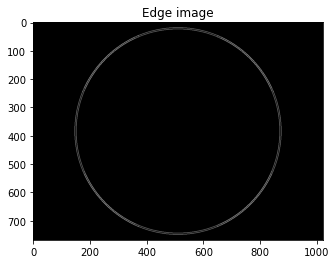

In [2]:
Gaussianimg = cv2.GaussianBlur(img,(5,5),7) 
ced = cv2.Canny(Gaussianimg, 50, 100)
print(ced.shape)
plt.imshow(ced,cmap = 'gray')
plt.title("Edge image")

The functions to calculate circle

371.84580900661985
[391.2546012269939, 521.0398773006136]


Text(0.5, 1.0, 'Debug img')

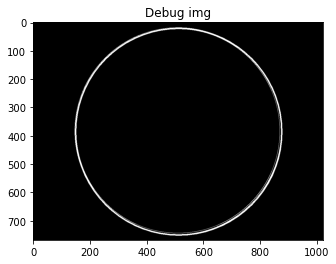

In [3]:
def findpoint(img): 
    line = []
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if img[i,j]==255:
                line.append([i,j])
    points = random.sample(line, 3)
   # print("Sample points: ",points)
    return points

def calculatemid(points):
#     points = findpoint(img)
    x1 = ((points[0][0])+(points[1][0]))/2
    y1 = ((points[0][1])+(points[1][1]))/2
    x2 = ((points[1][0])+(points[2][0]))/2
    y2 = ((points[1][1])+(points[2][1]))/2
    mid1=[x1,y1]
    mid2=[x2,y2]
    mid = [mid1,mid2]
    #print("Middle points: ",mid)
    return mid


def slope(img,points):
    pm = []
    if((points[0][0]-points[1][0]) == 0 or (points[1][0]-points[2][0]) == 0 or (points[0][0] == 0) or (points[0][1] == 0) or 
       (points[1][0] == 0) or (points[1][1] == 0) or (points[2][0] == 0) or (points[2][1] == 0)):
        points = findpoint(img)
        return slope(img, points)
    else:
        m1= (points[0][1]-points[1][1])/(points[0][0]-points[1][0])
        m2 =(points[1][1]-points[2][1])/(points[1][0]-points[2][0])
        if(m1==0 or m2==0 or m1-m2==0):
            points = findpoint(img)
            return slope(img, points)
        else:
            pm1 = -(1/m1)
            pm2 = -(1/m2)
            pm = [pm1,pm2]
            return pm

def sloperand(line,points):
    pm = []
    if((points[0][0]-points[1][0]) == 0 or (points[1][0]-points[2][0]) == 0 or (points[0][0] == 0) or (points[0][1] == 0) or 
       (points[1][0] == 0) or (points[1][1] == 0) or (points[2][0] == 0) or (points[2][1] == 0)):
        points = randpoints(line)
        return slope(line,points)
    else:
        m1= (points[0][1]-points[1][1])/(points[0][0]-points[1][0])
        m2 =(points[1][1]-points[2][1])/(points[1][0]-points[2][0])
        if(m1==0 or m2==0 or m1-m2==0):
            points = findpoint(img)
            return slope(img, points)
        else:
            pm1 = -(1/m1)
            pm2 = -(1/m2)
            pm = [pm1,pm2]
            return pm
samplePoint = findpoint(ced)
mid = calculatemid(samplePoint)
pm  = slope(ced, samplePoint)

b1= (mid[0][1]) - pm[0]*mid[0][0]
b2 = (mid[1][1]) - pm[1]*mid[1][0]

x=(b2-b1)/(pm[0]-pm[1])
y=pm[0]*x+b1
 

center  = [x,y]
distance  = math.sqrt((samplePoint[0][0] - center[0])**2 + (samplePoint[0][1]-center[1])**2)
           
print(distance)
print(center)
debug = cv2.circle(ced,(514,386),364,(255,0,0),3 )
plt.imshow(debug,cmap = 'gray')
plt.title("Debug img")

The functions to calculate inlier points

In [4]:
line = []
for i in range(rows):
    for j in range(columns):
        if ced[i,j]==255:
            line.append([i,j])

def Randompoint(line1):

    temp = random.sample(line1,3)
    return temp


## Record the number of inlier points
def Inliercal(testline1,line1):
    inlier = 0
    inlier = len([x for x in testline1 if x in line1])
    return inlier

## Record the inlier point
def Inlierpoint(testline1,line1):
    inlier = 0
    inlier = [x for x in testline1 if x in line1]
    return inlier

The step1.3 and step 1.4 for the big circle (red for 1.3 and blue for 1.4)   20times 

██████████████████████████████████████████████████████████████████████100% For iteration =20 [384.45961274 512.67763105]
386 514
364.16617086159994
[384.45961274 512.67763105]
363


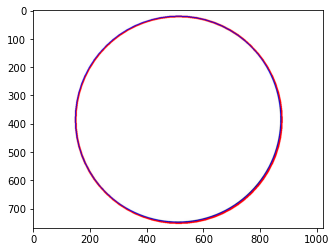

In [5]:
K=0
I=0
C=-1 
Inlier =0

## for loop for ransac
for i in range(Grange[0],Grange[1]+1):
    imgini = np.zeros((rows,columns),dtype = np.uint8)
##  Generate the random circle 
    testpoints = Randompoint(line)
    testmid = calculatemid(testpoints)
    testpm  = slope(ced, testpoints)
    tb1= (testmid[0][1]) - testpm[0]*testmid[0][0]
    tb2 = (testmid[1][1]) - testpm[1]*testmid[1][0]
    tx=(tb2-tb1)/(testpm[0]-testpm[1])
    
    ty=testpm[0]*tx+tb1
    bestcenter = (int(ty),int(tx))
    bestr = math.sqrt((testpoints[0][0] - bestcenter[1])**2 + (testpoints[0][1]-bestcenter[0])**2)
    testcircle = cv2.circle(imgini,(int(ty),int(tx)),int(bestr),(255,0,0),5)
    testline = []
    for f in range(testcircle.shape[0]):
        for l in range(testcircle.shape[1]):
            if testcircle[f,l]==255:
                testline.append([f,l])
    Inlier = Inliercal(testline, line)

    if Inlier > K:
        K = Inlier
        C=K
        Rb = bestr
        Cb = bestcenter
        inlierpoint = Inlierpoint(testline,line)
        impoints = Randompoint(Inlierpoint(testline,line))
    pctge = (i - Grange[0]) / (Grange[1] - Grange[0])
    temp = int(round(pBarLength * pctge))
    print("\r"+(temp-1)*'█'+'█'+(pBarLength-temp)*'░'+str(round(pctge*100))+'%'+" For iteration ="+str(i),end=' ')
    I = I+1

##  step 1.4 for first circle

Bcircle = cv2.circle(img,(int(Cb[0]),int(Cb[1])),int(Rb),(255,0,0),5)

meanCenter = np.mean(inlierpoint,axis=0)
print(meanCenter)
dis = []
tdis = []
for i in range (len(inlierpoint)):
    dis.append(np.sqrt((inlierpoint[i][0] - meanCenter[0])**2 + (inlierpoint[i][1] - meanCenter[1])**2))

radNew = int(np.mean(dis,axis=0))

imcircle = cv2.circle(Bcircle,(int(meanCenter[1]),int(meanCenter[0])),int(radNew),(0,0,255),2)

plt.imshow(imcircle)
print(Cb[1],Cb[0])
print(Rb)
print(meanCenter)
print(radNew)





The step1.3 and step 1.4 for the concentric_circles (red for 1.3 and blue for 1.4)

Text(0.5, 1.0, 'Canny edge detection')

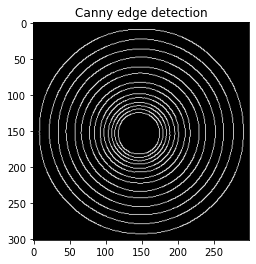

In [6]:
imgGray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
Gaussianimg = cv2.GaussianBlur(imgGray,(5,5),7) 
cedcon = cv2.Canny(Gaussianimg, 50, 300)
plt.imshow(cedcon,cmap ='gray')
plt.title("Canny edge detection")

302
██████████████████████████████████████████████████████████████████████100% For iteration =2000 150 514
142.30249470757707
[151.25478927 150.11877395]
142


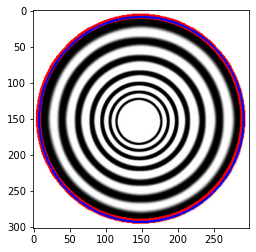

In [7]:
conline= []
conrow  = cedcon.shape[0]
concol = cedcon.shape[1]
for i in range(conrow):
    for j in range(concol):
        if cedcon[i,j]==255:
            conline.append([i,j])
print(conrow)
Kcon=0 
Ccon=0

## for loop for ransac
for i in range(krange[0],krange[1]+1):
    imgini1 = np.zeros((conrow,concol),dtype = np.uint8)
    testpoints1 = Randompoint(conline)
    testmid1 = calculatemid(testpoints1)
    testpm1  = slope(cedcon, testpoints1)
    tb1con= (testmid1[0][1]) - testpm1[0]*testmid1[0][0]
    tb2con = (testmid1[1][1]) - testpm1[1]*testmid1[1][0]
    tx1=(tb2con-tb1con)/(testpm1[0]-testpm1[1])
    
    ty1=testpm1[0]*tx1+tb1con
    bestcenter1 = (int(ty1),int(tx1))
    bestr1 = math.sqrt((testpoints1[0][0] - bestcenter1[1])**2 + (testpoints1[0][1]-bestcenter1[0])**2)
    testcircle1 = cv2.circle(imgini1,(int(ty1),int(tx1)),int(bestr1),(255,0,0),5)
    testline1 = []
    for f in range(testcircle1.shape[0]):
        for l in range(testcircle1.shape[1]):
            if testcircle1[f,l]==255:
                testline1.append([f,l])
    Inlier1 = Inliercal(testline1, conline)
    if Inlier1 > Kcon:
        Kcon = Inlier1
        Ccon=Kcon
        Rbcon = bestr1
        Cbcon = bestcenter1
        inlierpoint1 = Inlierpoint(testline1,conline)
        impoints1 = Randompoint(Inlierpoint(testline1,conline))
#         print("\nUpdate")
#         print("Best: ",Cbcon,Rbcon)

#     for i in range(len(Inlier)):
#         distance = math.sqrt( ((genercir_cen[i][0]-inlierpoints[i][0])**2)+((genercir_cen[i][1]-inlierpoints[i][1])**2))
#         sumdis = sumdis + distance
    pctge = (i - 1) / (krange[1] - 1)
    temp = int(round(pBarLength * pctge))
    print("\r"+(temp-1)*'█'+'█'+(pBarLength-temp)*'░'+str(round(pctge*100))+'%'+" For iteration ="+str(i),end=' ')
    I = I+1

Bcircle1 = cv2.circle(img1,(int(Cbcon[0]),int(Cbcon[1])),int(Rbcon),(0,0,255),5)

Bcircle1 = cv2.cvtColor(Bcircle1,cv2.COLOR_BGR2RGB)
# print("\nbest result ",Cbcon,Rbcon,"\nBest Inlier",Kcon)
meanCenter1 = np.mean(inlierpoint1,axis=0)
dis1 = []
for i in range (len(inlierpoint1)):
    dis1.append(np.sqrt((inlierpoint1[i][0] - meanCenter1[0])**2 + (inlierpoint1[i][1] - meanCenter1[1])**2))
radNew1 = int(np.mean(dis1))
imcircle1 = cv2.circle(Bcircle1,(int(meanCenter1[1]),int(meanCenter1[0])),int(radNew1),(0,0,255),2)

plt.imshow(imcircle1)
print(Cbcon[1],Cb[0])
print(Rbcon)
print(meanCenter1)
print(radNew1)

            

    
    

###### 

The step1.3 and step 1.4 for the big circle (red for 1.3 and blue for 1.4)

Text(0.5, 1.0, 'Canny edge detection')

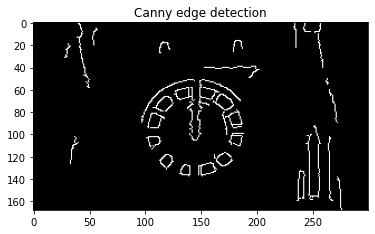

In [8]:
imgGray = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
Gaussianimg = cv2.GaussianBlur(imgGray,(5,5),10) 
cedclock = cv2.Canny(Gaussianimg, 150, 300)
plt.imshow(cedclock,cmap ='gray')
plt.title("Canny edge detection")

██████████████████████████████████████████████████████████████████████100% For iteration =5000 93 144
41.23105625617661
[ 93.75232198 145.20433437]
41


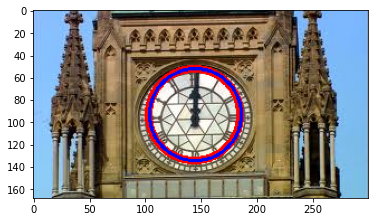

In [9]:
clockline= []
clockrow  = cedclock.shape[0]
clockcol = cedclock.shape[1]
for i in range(clockrow):
    for j in range(clockcol):
        if cedclock[i,j]==255:
            clockline.append([i,j])

Kcl=0 
Ccl=0
I = 0
## for loop for ransac
for i in range(crange[0],crange[1]+1):
    imgini2 = np.zeros((clockrow,clockcol),dtype = np.uint8)
    testpoints2 = Randompoint(clockline)
    testmid2 = calculatemid(testpoints2)
    testpm2  = slope(cedclock, testpoints2)
    tb1cl= (testmid2[0][1]) - testpm2[0]*testmid2[0][0]
    tb2cl = (testmid2[1][1]) - testpm2[1]*testmid2[1][0]
    tx2=(tb2cl-tb1cl)/(testpm2[0]-testpm2[1])
    
    ty2=testpm2[0]*tx2+tb1cl
    bestcenter2 = (int(ty2),int(tx2))
    bestr2 = math.sqrt((testpoints2[0][0] - bestcenter2[1])**2 + (testpoints2[0][1]-bestcenter2[0])**2)
    testcircle2 = cv2.circle(imgini2,(int(ty2),int(tx2)),int(bestr2),(255,0,0),5)
    testline2 = []
    for f in range(testcircle2.shape[0]):
        for l in range(testcircle2.shape[1]):
            if testcircle2[f,l]==255:
                testline2.append([f,l])
    Inlier2 = Inliercal(testline2, clockline)
    if Inlier2 > Kcl:
        Kcl = Inlier2
        Ccl=Kcl
        Rbcl = bestr2
        Cbcl = bestcenter2
        inlierpoint2 = Inlierpoint(testline2,clockline)
        impoints2 = Randompoint(Inlierpoint(testline2,clockline))
#         print("\nUpdate")
#         print("Best: ",Cbcl,Rbcl)

#     for i in range(len(Inlier)):
#         distance = math.sqrt( ((genercir_cen[i][0]-inlierpoints[i][0])**2)+((genercir_cen[i][1]-inlierpoints[i][1])**2))
#         sumdis = sumdis + distance
    pctge = (i - 1) / (crange[1] - 1)
    temp = int(round(pBarLength * pctge))
    print("\r"+(temp-1)*'█'+'█'+(pBarLength-temp)*'░'+str(round(pctge*100))+'%'+" For iteration ="+str(i),end=' ')
    I = I+1

Bcircle2 = cv2.circle(img2,(int(Cbcl[0]),int(Cbcl[1])),int(Rbcl),(0,0,255),5)

Bcircle2 = cv2.cvtColor(Bcircle2,cv2.COLOR_BGR2RGB)
meanCenter2 = np.mean(inlierpoint2,axis=0)
dis2 = []
for i in range (len(inlierpoint2)):
    dis2.append(np.sqrt((inlierpoint2[i][0] - meanCenter2[0])**2 + (inlierpoint2[i][1] - meanCenter2[1])**2))
radNew2 = int(np.mean(dis2))
imcircle2 = cv2.circle(Bcircle2,(int(meanCenter2[1]),int(meanCenter2[0])),int(radNew2),(0,0,255),2)

plt.imshow(imcircle2)
print(Cbcl[1],Cbcl[0])
print(Rbcl)
print(meanCenter2)
print(radNew2)
